<a href="https://colab.research.google.com/github/YE-Hordijk/DeepLearning2/blob/main/Copy_of_Copy_of_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://surfdrive.surf.nl/files/index.php/s/B8emtQRGUeAaqmz/download
!unzip download -d ./

--2022-11-24 12:19:45--  https://surfdrive.surf.nl/files/index.php/s/B8emtQRGUeAaqmz/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 319538742 (305M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 304.74M  20.4MB/s    in 16s     

2022-11-24 12:20:02 (18.6 MB/s) - ‘download’ saved [319538742/319538742]

Archive:  download
  inflating: ./images.npy            
  inflating: ./labels.npy            


In [ ]:
images = np.load("images.npy").reshape(18000, 150*150)
labels = np.load("labels.npy")
tot = np.append(images, labels, axis=1)
tot = tot.astype("float32")
np.random.shuffle(tot)
images, labels = tot[:,:22500].reshape(18000, 150, 150), tot[:,22500:]
images = images/255

#use the first line for regression, the second for classification and neither for multi-head
# labels = labels[:,0] + labels[:,1]/60
# labels = (labels[:,0]*2 +labels[:,1]/30).astype("int32")

trainx, trainy = images[:int(18000*0.8)], labels[:int(18000*0.8)]
testx, testy = images[int(18000*0.8):], labels[int(18000*0.8):]

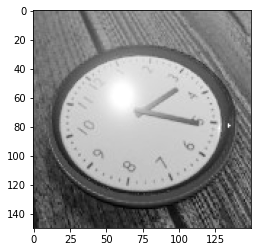

In [ ]:
plt.imshow(images[0], cmap="gray")
plt.show()

In [ ]:
def lossfuncreg(ytrue, ypred):
  return tf.math.minimum(tf.math.abs((ytrue+12 - ypred)%12), tf.math.abs((ypred+12 - ytrue)%12))

def lossfuncmulti(ytrue, ypred):
  return (tf.math.minimum((ytrue - ypred)%60, (ypred - ytrue)%60))/8
  # return tf.math.minimum(tf.math.abs((ytrue+60 - ypred)%60), tf.math.abs((ypred+60 - ytrue)%60))

In [ ]:
#regression model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (10, 10), strides=(3, 3), activation="relu", input_shape=(150, 150, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(1, activation="linear"))
model.summary()

model.compile(
    loss=lossfuncreg,
    optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999, epsilon=1e-07),
    metrics=[keras.metrics.MeanSquaredError()]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 49, 49, 32)        1184      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 128)       

In [ ]:
#classification model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (10, 10), strides=(3, 3), activation="relu", input_shape=(150, 150, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(24, activation="softmax"))
model.summary()

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999, epsilon=1e-07),
    metrics=["accuracy"]
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 47, 47, 32)        3232      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 128)       

In [ ]:
#multi head model
inp = keras.Input(shape=(150, 150, 1))

x = keras.layers.Conv2D(32, (10, 10), strides=(3, 3), activation='relu')(inp)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Flatten()(x)
  
hour = keras.layers.Dense(256, activation='relu')(x)
hour = keras.layers.Dense(12, activation='softmax', name='hour')(hour)

minute = keras.layers.Dense(256, activation='relu')(x)
minute = keras.layers.Dense(64, activation='relu')(minute)
minute = keras.layers.Dense(1, activation='linear', name='minute')(minute)

model = keras.Model(inputs=inp, outputs=[hour, minute])

model.compile(
    loss=["sparse_categorical_crossentropy", lossfuncmulti],
    optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999, epsilon=1e-07),
    metrics=["accuracy", "mse"]
)

In [ ]:
# history = model.fit(trainx, trainy, epochs=100, batch_size=64)                        #use this for regression and classification
callback = keras.callbacks.EarlyStopping(monitor="val_loss", verbose=1, patience=20)
history = model.fit(trainx, [trainy[:,0], trainy[:,1]], epochs=100, batch_size=64, validation_split=0.1, callbacks=[callback], shuffle=True)    #use this for multi-head
model.save("task2model")

Epoch 1/100
 96/203 [=============>................] - ETA: 2:00 - loss: 4.3761 - hour_loss: 2.4866 - minute_loss: 1.8894 - hour_accuracy: 0.0841 - minute_accuracy: 0.0166

KeyboardInterrupt: ignored

In [ ]:
#regression
# predmodel = keras.models.load_model("./task2model", custom_objects={"lossfuncreg":lossfuncreg})
# predictions = predmodel.predict(testx)
# print("average absolute difference: ", np.average(np.absolute(((predictions%12)[:,0] - testy))))


#classification
# predmodel = keras.models.load_model("./task2model") #classification
# predictions = predmodel.predict(testx)
# print("accuracy: ", np.sum(np.argmax(predictions, axis=1) == testy) / len(testy))

#multi-head
predmodel = keras.models.load_model("./task2model", custom_objects={"lossfuncmulti":lossfuncmulti})
predictions = predmodel.predict(testx)
print(predictions[1])
print(predictions[1][:,0]%60)
print(testy[:,1])
print("hour accuracy: ", np.sum(np.argmax(predictions[0], axis=1) == testy[:,0]) / len(testy))
print("average absolute difference minutes: ", np.average(np.absolute(predictions[1][:,0]%60 - testy[:,1])))


113/113 [==============================] - 1s 7ms/step
[[-31.493937]
 [-21.546587]
 [-21.171211]
 ...
 [  6.015743]
 [ 11.44667 ]
 [-43.055416]]
[28.506063 38.453415 38.82879  ...  6.015743 11.44667  16.944584]
[29. 39. 41. ... 15. 16.  9.]
hour accuracy:  0.8894444444444445
average absolute difference minutes:  6.5890417


In [ ]:
from google.colab import files
files.download("/content/task2model")

FileNotFoundError: ignored

In [ ]:
#Optimized multi-head model
inp = keras.Input(shape=(150, 150, 1))

x = keras.layers.Conv2D(32, (10, 10), strides=2)(inp)
x = keras.layers.LeakyReLU(alpha=0.05)(x)
# x = keras.layers.BatchNormalization()(x)

x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(64, (4, 4))(x)
x = keras.layers.LeakyReLU(alpha=0.05)(x)
# x = keras.layers.BatchNormalization()(x)

x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.Conv2D(128, (3, 3), padding="same")(x)
x = keras.layers.LeakyReLU(alpha=0.05)(x)
# # x = keras.layers.BatchNormalization()(x)

x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# x = keras.layers.Conv2D(64, (3, 3), strides=2, padding="same")(x)
# x = keras.layers.LeakyReLU(alpha=0.05)(x)
# # x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dropout(.4)(x)
x = keras.layers.Flatten()(x)
  
hour = keras.layers.Dense(256)(x)
hour = keras.layers.LeakyReLU(alpha=0.05)(hour)
hour = keras.layers.Dense(12, activation='softmax', name='hour')(hour)

minute = keras.layers.Dense(256)(x)
minute = keras.layers.LeakyReLU(alpha=0.05)(minute)
# minute = keras.layers.Dense(64, activation='relu')(minute)
minute = keras.layers.Dense(1, activation='linear', name='minute')(minute)

model = keras.Model(inputs=inp, outputs=[hour, minute])

model.compile(
    loss=["sparse_categorical_crossentropy", lossfuncmulti],
    optimizer=keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.9,beta_2=0.999, epsilon=1e-07),
    metrics=["accuracy"]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 71, 71, 32)   3232        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 71, 71, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 35, 35, 32)   0           ['leaky_re_lu[0][0]']        